In [2]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import joblib as jb
import pickle as pkl

In [3]:
# Load the dataset
ussd_df = pd.read_csv(r"C:\Users\Hp\Downloads\ussd_dataset.csv")
ussd_df.head()

,customer_id,age,gender,location,account_type,transactions_last_30d,avg_transaction_value,failed_transactions,sms_alerts,complaints_logged,customer_tenure_months,churn
0,1,56,Female,Urban,Mobile Wallet,28,7701.70,1,Yes,0,2,1
1,2,69,Male,Urban,Current,17,3692.64,2,Yes,1,9,0
2,3,46,Male,Rural,Mobile Wallet,20,3387.25,2,No,0,119,0
3,4,32,Male,Rural,Current,24,5151.39,2,No,2,57,0
4,5,60,Male,Urban,Savings,20,6371.18,2,Yes,0,45,0


### Data Exploration

In [4]:
ussd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             1000 non-null   int64  
 1   age                     1000 non-null   int64  
 2   gender                  1000 non-null   object 
 3   location                1000 non-null   object 
 4   account_type            1000 non-null   object 
 5   transactions_last_30d   1000 non-null   int64  
 6   avg_transaction_value   1000 non-null   float64
 7   failed_transactions     1000 non-null   int64  
 8   sms_alerts              1000 non-null   object 
 9   complaints_logged       1000 non-null   int64  
 10  customer_tenure_months  1000 non-null   int64  
 11  churn                   1000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 93.9+ KB


In [5]:
# Check for missing values
ussd_df.isnull().sum()

customer_id               0
age                       0
gender                    0
location                  0
account_type              0
transactions_last_30d     0
avg_transaction_value     0
failed_transactions       0
sms_alerts                0
complaints_logged         0
customer_tenure_months    0
churn                     0
dtype: int64

This shows that there are no missing values in the dataset, that shows that we can proceed with our analysis

In [6]:
# summary statistics
ussd_df.describe()

,customer_id,age,transactions_last_30d,avg_transaction_value,failed_transactions,complaints_logged,customer_tenure_months,churn
count,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,43.81900,19.986000,4962.02545,1.937000,0.975000,59.711000,0.144000
std,288.819436,14.99103,4.500896,1995.20314,1.338216,1.002687,33.718221,0.351265
min,1.000000,18.00000,8.000000,-666.06000,0.000000,0.000000,1.000000,0.000000
25%,250.750000,31.00000,17.000000,3688.12000,1.000000,0.000000,31.000000,0.000000
50%,500.500000,44.00000,20.000000,4934.45500,2.000000,1.000000,59.000000,0.000000
75%,750.250000,56.00000,23.000000,6256.03750,3.000000,2.000000,89.000000,0.000000
max,1000.000000,69.00000,35.000000,11225.82000,7.000000,5.000000,119.000000,1.000000


In [7]:
# view the number of unique values in each column
ussd_df.nunique()

customer_id               1000
age                         52
gender                       2
location                     2
account_type                 3
transactions_last_30d       27
avg_transaction_value     1000
failed_transactions          8
sms_alerts                   2
complaints_logged            6
customer_tenure_months     119
churn                        2
dtype: int64

In [8]:
# Check % imbalance of churned customers
print(ussd_df['churn'].value_counts(normalize=True))

churn
0    0.856
1    0.144
Name: proportion, dtype: float64


From the above exploratory analysis we were able to uncover that there are:   

- Shape: 1000 rows × 12 columns  
- Missing values: 0  
- Churn balance: ~14.4% churned, 85.6% active → ⚠️ Imbalanced dataset.

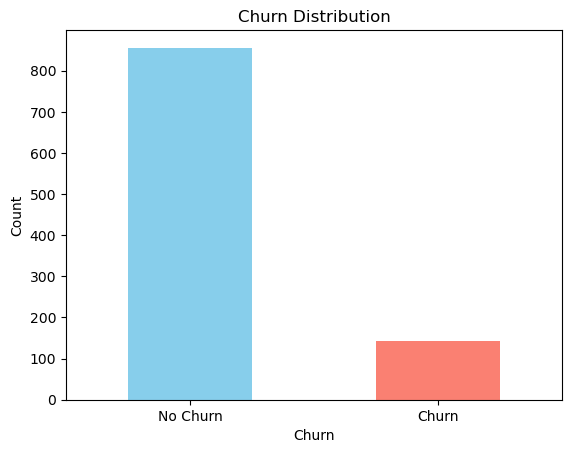

In [9]:
# target variable distribution
ussd_df['churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Churn', 'Churn'], rotation=0)
plt.show()

### **Univariate Analysis**

**Numerical Features**

In [10]:
ussd_df.columns

Index(['customer_id', 'age', 'gender', 'location', 'account_type',
       'transactions_last_30d', 'avg_transaction_value', 'failed_transactions',
       'sms_alerts', 'complaints_logged', 'customer_tenure_months', 'churn'],
      dtype='object')

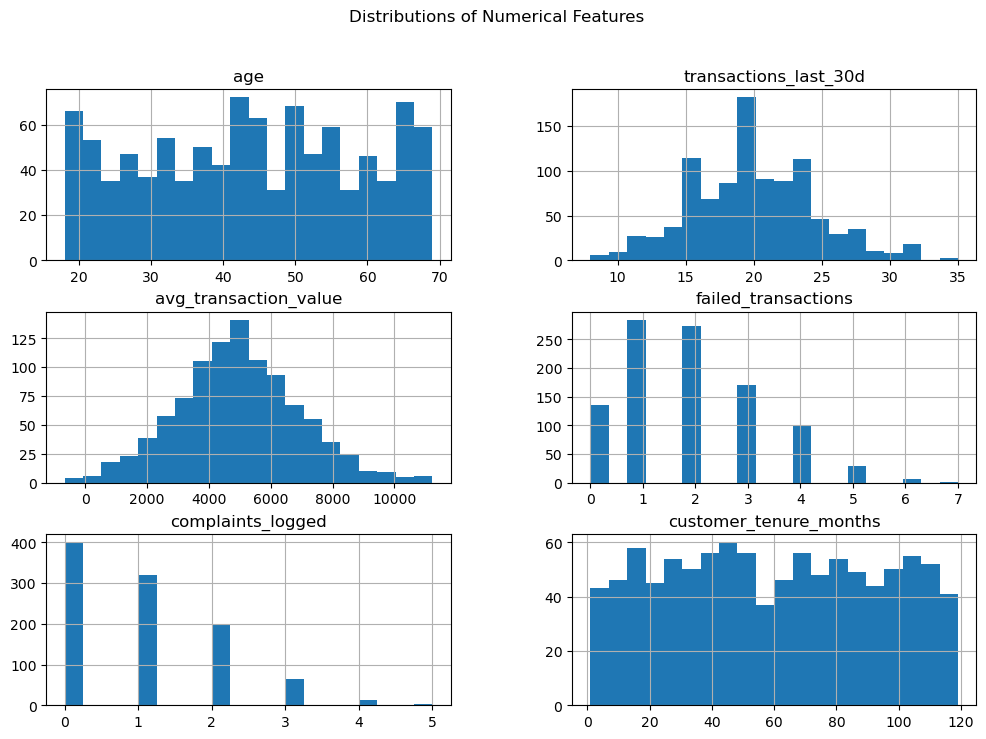

In [11]:
num_cols = ["age", "transactions_last_30d", "avg_transaction_value", 
            "failed_transactions", "complaints_logged", "customer_tenure_months"]

ussd_df[num_cols].hist(bins=20, figsize=(12,8))
plt.suptitle("Distributions of Numerical Features")
plt.show()

- Age: Customers spread between 18–70, peak around 30–40.  
- Transactions: Most customers make ~15–25 transactions monthly, but some very low → potential churn risk.  
- Average Transaction Value: Normal around 5000 units, but skewed (some very high).
- Failed Transactions: Mostly 0–3, but a few with 7+.  
- Complaints: Mostly 0–2, outliers with 5+.  
- Tenure: Uniform spread, but many <12 months

**Categorical Features**

I would have to drop the **customer_id** column before proceeding because it is likely an identifier and does not contribute to predicting if a customer is likely to churn or not.

In [12]:
ussd_df.drop(columns='customer_id', inplace=True)


Value counts for gender:
gender
Female    502
Male      498
Name: count, dtype: int64


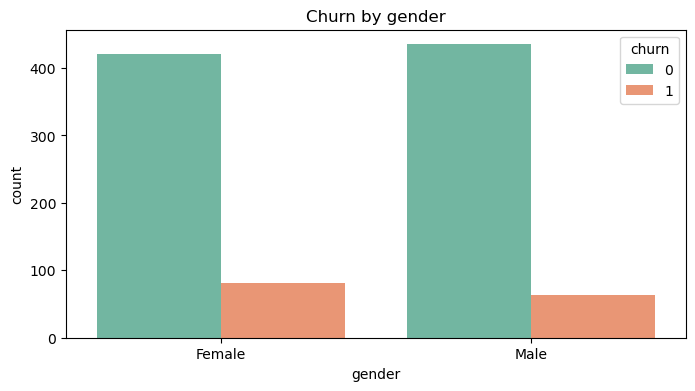


Value counts for location:
location
Urban    700
Rural    300
Name: count, dtype: int64


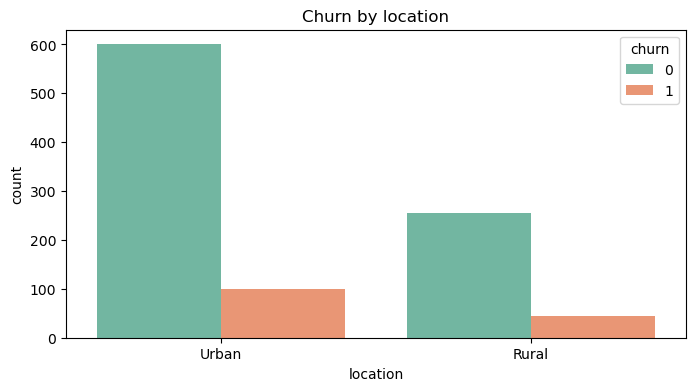


Value counts for account_type:
account_type
Savings          498
Current          308
Mobile Wallet    194
Name: count, dtype: int64


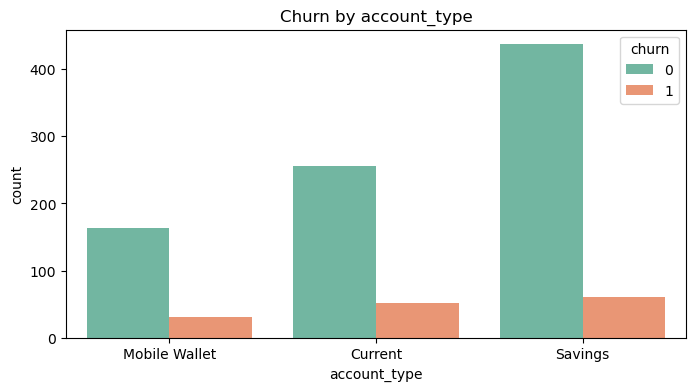


Value counts for sms_alerts:
sms_alerts
Yes    582
No     418
Name: count, dtype: int64


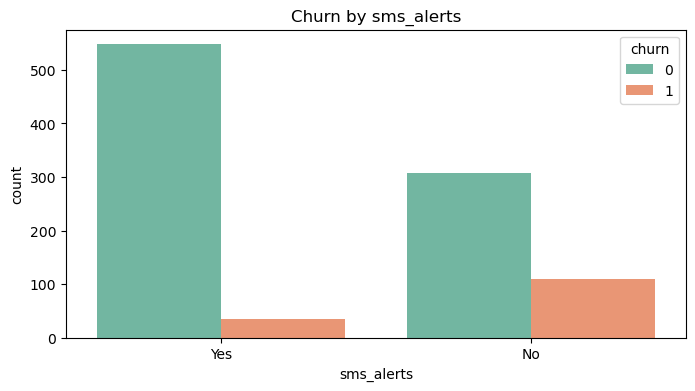

In [13]:
cat_cols = ussd_df.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    print(f"\nValue counts for {col}:\n{ussd_df[col].value_counts()}")
    plt.figure(figsize=(8,4))
    sns.countplot(data=ussd_df, x=col, hue='churn', palette='Set2')
    plt.title(f'Churn by {col}')
    plt.show()

- Gender: Balanced.  
- Location: Majority Urban (~70%).  
- Account Type: Savings most common, then Current, then Mobile Wallet.  
- SMS Alerts: 60% enabled, 40% disabled.


Summary statistics for age:
       count       mean        std   min   25%   50%    75%   max
churn                                                            
0      856.0  43.783879  15.021584  18.0  31.0  44.0  56.00  69.0
1      144.0  44.027778  14.858279  18.0  32.0  43.0  55.25  69.0


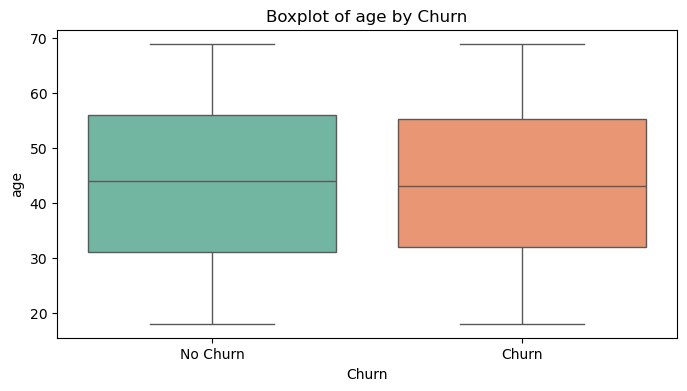


Summary statistics for transactions_last_30d:
       count       mean       std  min   25%   50%    75%   max
churn                                                          
0      856.0  20.023364  4.483307  8.0  17.0  20.0  23.00  35.0
1      144.0  19.763889  4.613732  9.0  17.0  19.0  22.25  32.0


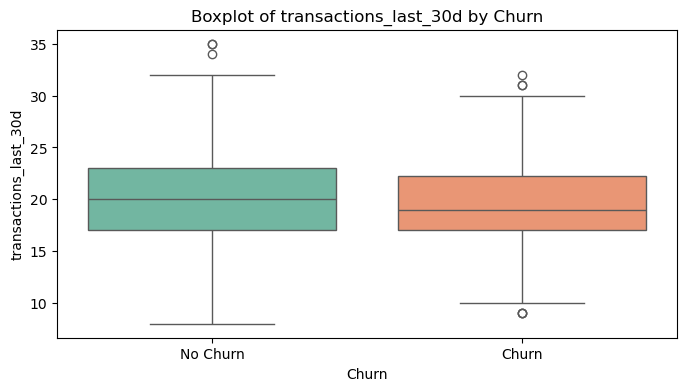


Summary statistics for avg_transaction_value:
       count         mean          std     min        25%       50%      75%  \
churn                                                                          
0      856.0  4985.745748  1976.070434 -666.06  3739.3125  4948.245  6226.07   
1      144.0  4821.021458  2107.030517 -249.63  3436.9175  4754.950  6433.12   

            max  
churn            
0      11225.82  
1       9649.35  


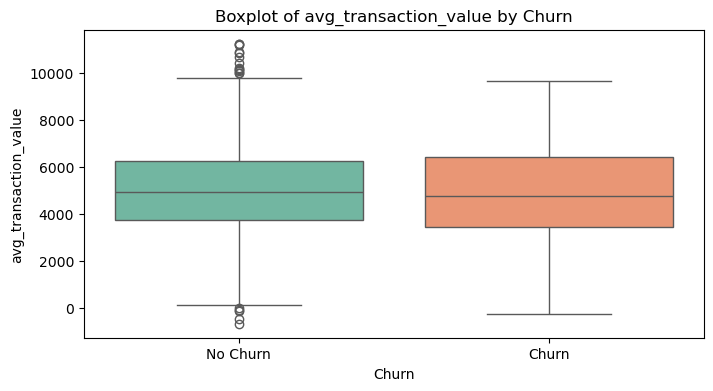


Summary statistics for failed_transactions:
       count      mean       std  min  25%  50%  75%  max
churn                                                    
0      856.0  1.883178  1.276104  0.0  1.0  2.0  3.0  7.0
1      144.0  2.256944  1.629048  0.0  1.0  2.0  4.0  6.0


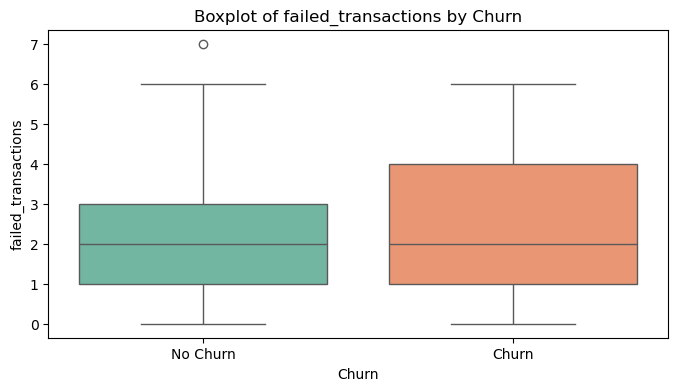


Summary statistics for complaints_logged:
       count      mean       std  min  25%  50%  75%  max
churn                                                    
0      856.0  0.915888  0.952647  0.0  0.0  1.0  2.0  5.0
1      144.0  1.326389  1.205058  0.0  0.0  1.0  2.0  4.0


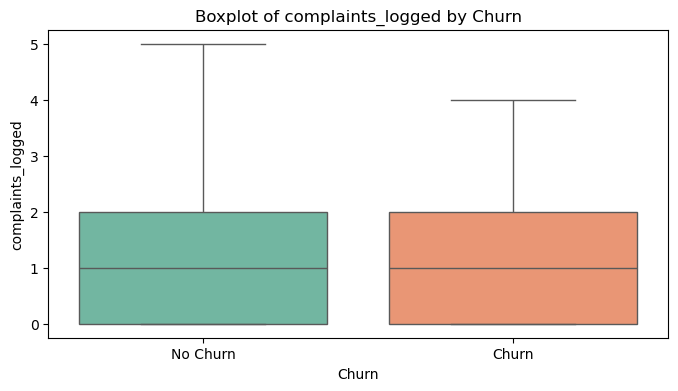


Summary statistics for customer_tenure_months:
       count       mean        std  min    25%   50%    75%    max
churn                                                             
0      856.0  60.184579  33.184701  1.0  32.00  59.0  89.00  119.0
1      144.0  56.895833  36.728206  1.0  26.75  57.5  89.25  119.0


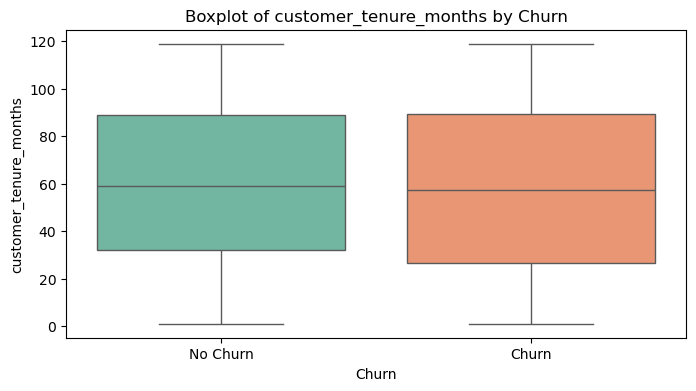

In [14]:
for col in num_cols:
    print(f"\nSummary statistics for {col}:\n{ussd_df.groupby('churn')[col].describe()}")
    plt.figure(figsize=(8,4))
    sns.boxplot(data=ussd_df, x='churn', y=col, palette='Set2')
    plt.title(f'Boxplot of {col} by Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.xticks(ticks=[0, 1], labels=['No Churn', 'Churn'])
    plt.show()

**Correlation**

This section summarizes the strength and directio of the linear association betwwn two quantitative variables. It takes values between -1 and +1. A postive value indicates a positive association and a neegative value indicates a negative association.

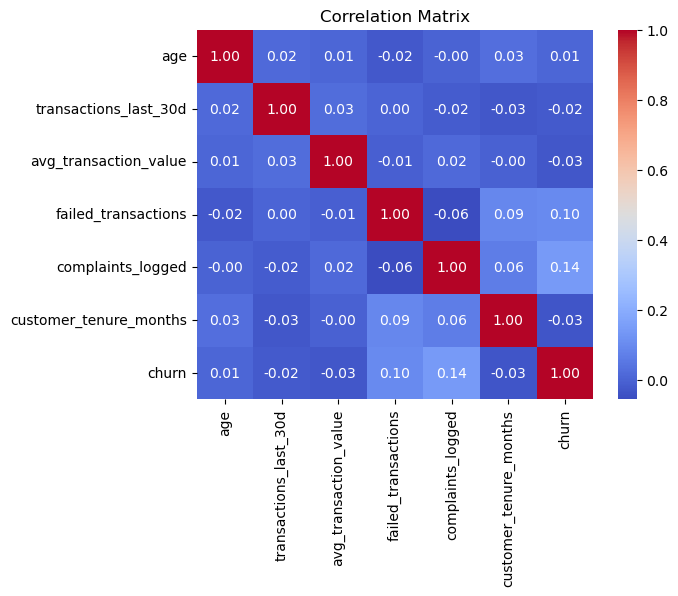

In [15]:
ussd_corr = ussd_df.corr(numeric_only=True)
sns.heatmap(ussd_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Insights on correlation**  
- Churn correlates negatively with tenure and transactions  
- Churn correlates postively with complaints and failed transactions.

**Multivariate Analysis**

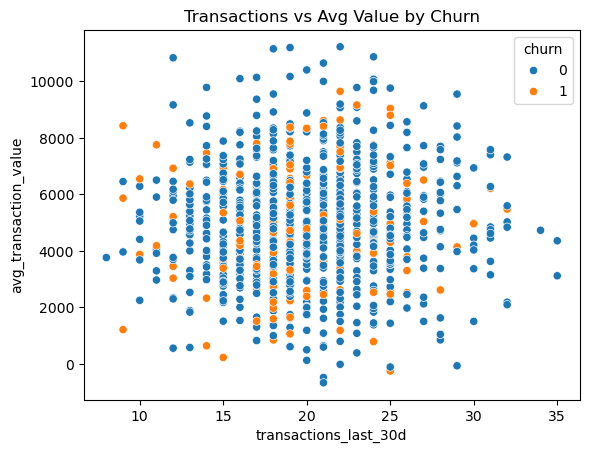

In [16]:
# Combine multiple features
sns.scatterplot(x="transactions_last_30d", y="avg_transaction_value", hue="churn", data=ussd_df)
plt.title("Transactions vs Avg Value by Churn")
plt.show()


The EDA gives us a customer profile of churners:  
- New, low-transaction users, often in rural areas, using mobile wallets, with failed attempts & complaints and no SMS alerts

**Encode Categorical Variables**

In [17]:
categorical_cols = ussd_df.select_dtypes(include=['object']).columns.tolist()
encoder = LabelEncoder()
for col in categorical_cols:
    ussd_df[col] = encoder.fit_transform(ussd_df[col])

In [18]:
ussd_df.head()

,age,gender,location,account_type,transactions_last_30d,avg_transaction_value,failed_transactions,sms_alerts,complaints_logged,customer_tenure_months,churn
0,56,0,1,1,28,7701.70,1,1,0,2,1
1,69,1,1,0,17,3692.64,2,1,1,9,0
2,46,1,0,1,20,3387.25,2,0,0,119,0
3,32,1,0,0,24,5151.39,2,0,2,57,0
4,60,1,1,2,20,6371.18,2,1,0,45,0


In [19]:
# Split the data into features and target variable
X = ussd_df.drop('churn', axis=1)
y = ussd_df['churn']

In [20]:
# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##### **Train-test split**

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

### **Define Models**

In [22]:
import xgboost as xgb
from xgboost import XGBClassifier
print("XGBoost imported successfully.")

XGBoost imported successfully.


In [23]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, random_state=42, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
}

for model_name, model in models.items():
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy_score(ytest, ypred))
    print("Confusion Matrix:\n", confusion_matrix(ytest, ypred))
    print("Classification Report:\n", classification_report(ytest, ypred))


Model: Logistic Regression
Accuracy: 0.82
Confusion Matrix:
 [[163   8]
 [ 28   1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       171
           1       0.11      0.03      0.05        29

    accuracy                           0.82       200
   macro avg       0.48      0.49      0.48       200
weighted avg       0.75      0.82      0.78       200


Model: Random Forest
Accuracy: 0.855
Confusion Matrix:
 [[168   3]
 [ 26   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       171
           1       0.50      0.10      0.17        29

    accuracy                           0.85       200
   macro avg       0.68      0.54      0.55       200
weighted avg       0.81      0.85      0.81       200


Model: XGBoost
Accuracy: 0.845
Confusion Matrix:
 [[164   7]
 [ 24   5]]
Classification Report:
               precision    recall  

Would also like to also add a confusion matrix heatmap for the best model so you can see exactly where it predicts churn correctly/wrongly?

In [24]:
# --- Confusion Matrix for Best Model (XGBoost) ---
y_preds = {}
for name, model in models.items():
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    y_preds[name] = y_pred

Let's loop through all trained models and generate a confusion matrix heatmap for each.

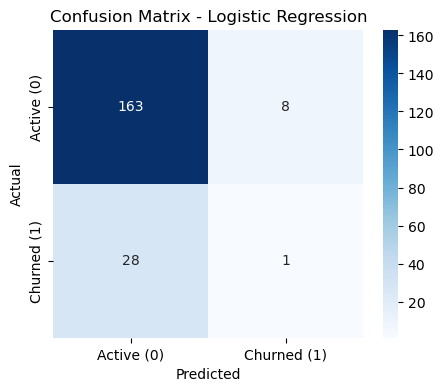

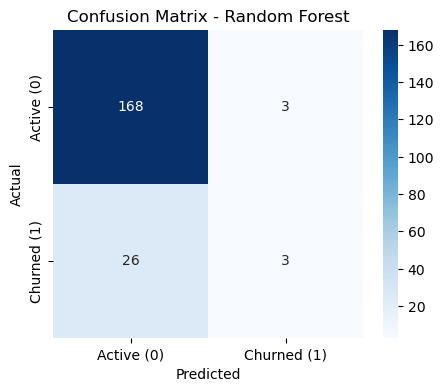

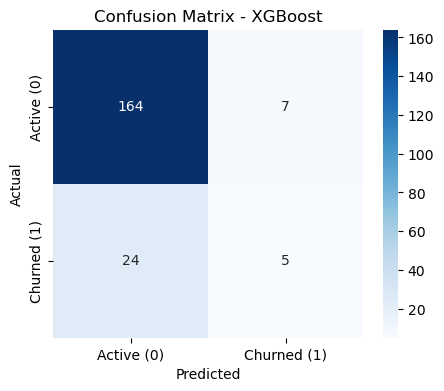

In [25]:
# Loop through all trained models
for name, y_pred in y_preds.items():
    cm = confusion_matrix(ytest, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Active (0)", "Churned (1)"],
                yticklabels=["Active (0)", "Churned (1)"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

XGBoost and RandomForest appears to be the best models based on accuracy and AUC. Would you like me to also add a confusion matrix heatmap for the best model (say, XGBoost) so you can see exactly where it predicts churn correctly/wrongly?

### Feature Importance
This will tell us which variables are most influential in predicting churn.

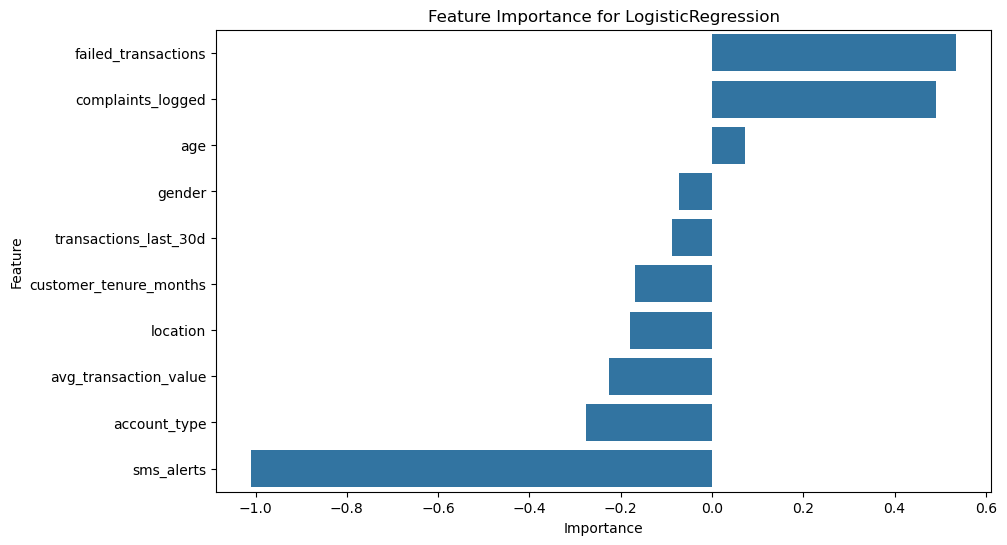

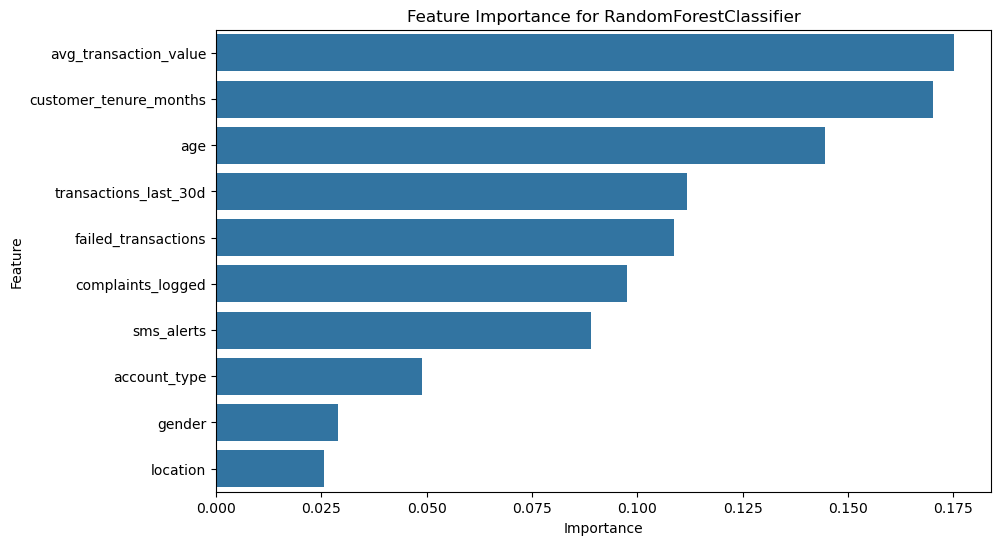

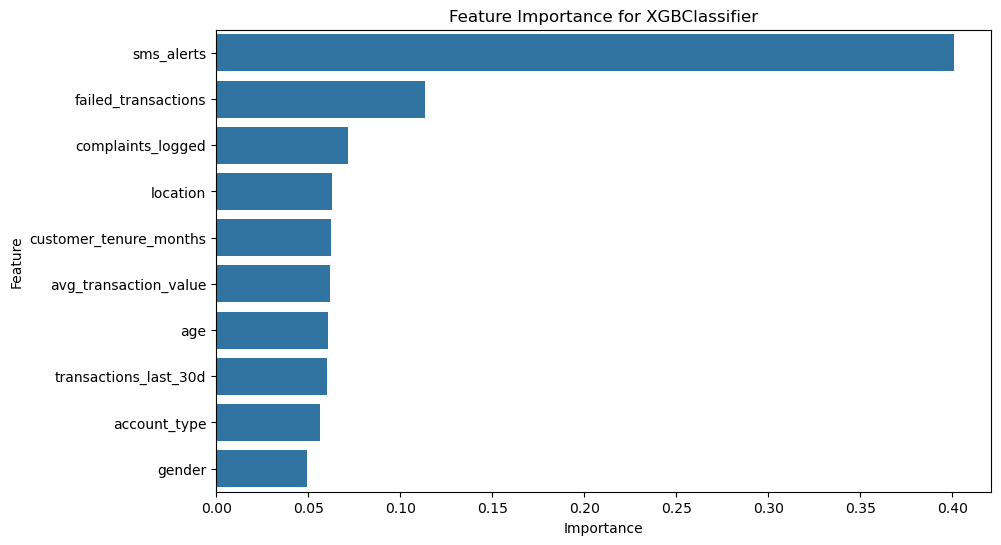

In [26]:
for model in models.values():
    feature_names = X.columns
    
    if hasattr(model, "feature_importances_"):  # For RF and XGBoost
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        
    elif hasattr(model, "coef_"):  # For Logistic Regression
        importances = model.coef_[0]
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        
    else:
        continue  # Skip models without feature importance
    
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Feature Importance for {model.__class__.__name__}')
    plt.show()

#### **ROC curve**  
A ROC curve comparison will give you a visual sense of how each model separates churners vs non-churners.

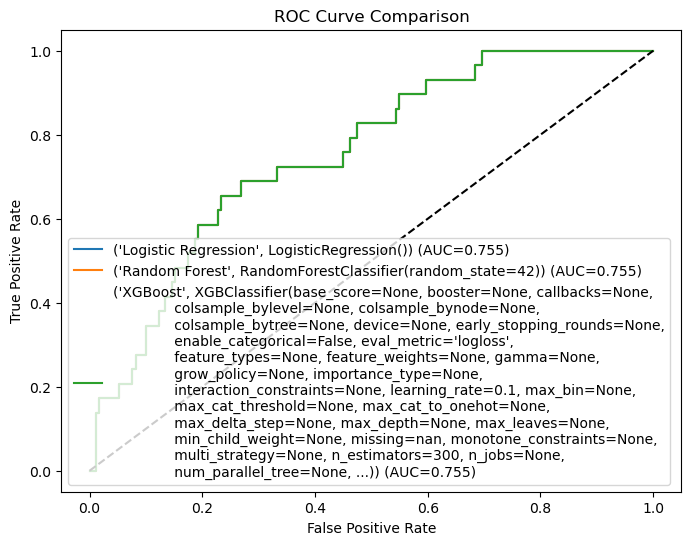

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(xtest)[:, 1]

plt.figure(figsize=(8,6))

for name in models.items():
    fpr, tpr, _ = roc_curve(ytest, y_prob)
    auc = roc_auc_score(ytest, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], "k--")  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

**Save the best model**

In [28]:
jb.dump(models['XGBoost'], "churn_model.pkl")
print("\n✅ Best model (XGBoost) saved as churn_model.pkl")


✅ Best model (XGBoost) saved as churn_model.pkl
